<a href="https://www.kaggle.com/code/parisrohan/rp-customer-segmentation?scriptVersionId=96573856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**What is Customer Segmentation?**
Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.

**Types of Segmentation factors:**
* Demographic (Age, Gender, Income, Location, Education, Ethnicity)
* Psychographic (Interests, Lifestyles, Priorities, Motivation, Influence)
* Behavioural (Purchasing habits, Spending habits, User status, Brand interactions)
* Geographic (zip code, city, country, climate)

**Why Segment Customers?**
* Test pricing options
* Focus on the most profitable customers
* Increase brand awareness
* Create and communicate targeted marketing messages


## Data collection and initial analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [2]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for datetime operations
import datetime as dt

#for stats and plotting
import scipy.stats as stat
import pylab 

#for feature scaling
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
#read the dataset and store it into a dataframe
df_data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
#check the number of rows and columns present
df_data.shape

(1067371, 8)

**Observation**: Our dataset has 1067371 rows and 8 columns

In [5]:
#Check the feature datatypes
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


**Observation**: Features having null values are - Description, Customer ID

In [6]:
#making sure the above observation is correct
df_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

### Feature Description
* **InvoiceNo:** Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

* **StockCode:** Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

* **Description:** Product (item) name. Nominal.

* **Quantity:** The quantities of each product (item) per transaction. Numeric.

* **InvoiceDate:** Invice date and time. Numeric. The day and time when a transaction was generated.

* **UnitPrice:** Unit price. Numeric. Product price per unit in sterling (Â£).

* **CustomerID:** Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

* **Country:** Country name. Nominal. The name of the country where a customer resides.

### Analyzing Country feature

In [7]:
#Countries where the customers reside
df_data['Country'].value_counts()

United Kingdom          981330
EIRE                     17866
Germany                  17624
France                   14330
Netherlands               5140
Spain                     3811
Switzerland               3189
Belgium                   3123
Portugal                  2620
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1364
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Unspecified                756
Greece                     663
Japan                      582
Poland                     535
USA                        535
United Arab Emirates       500
Israel                     371
Hong Kong                  364
Singapore                  346
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        169
Bahrain 

**Observation** : There are 756 entries with Country name as Unspecified.
This means that these are actually EMPTY/NULL values.

In [8]:
#We will delete records having 'Unspecified' country
index_name = df_data[df_data['Country']=='Unspecified'].index
df_data.drop(index_name, inplace=True)

([<matplotlib.patches.Wedge at 0x7fd6c6218490>,
 [Text(-1.5982156257492242, 0.41013023981537405, 'Yes'),
  Text(1.5982156257492242, -0.4101302398153742, 'No')],
 [Text(-0.8717539776813948, 0.22370740353565854, '92.0%'),
  Text(0.8717539776813948, -0.22370740353565863, '8.0%')])

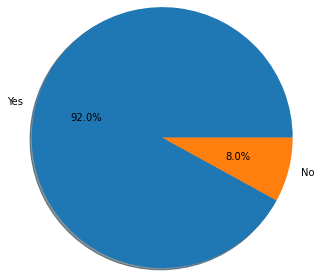

In [9]:
#Create a feature named as Internal_Market which will contain Yes value if the customer is from UK, else it will have no value
df_data['Internal_Market']=df_data['Country'].apply(lambda x: 'Yes' if x=='United Kingdom' else 'No')

#Store the country name
market =df_data.Internal_Market.value_counts().index

#Store the count value
market_count=df_data.Internal_Market.value_counts().values

#Plot a pie chart showing the countries that use Zomato
plt.pie(market_count, labels=market, autopct='%1.1f%%', shadow=True, radius=1.5)

**Observation:** The above pie plot shows that majority of customers are from internal market i.e UK

In [10]:
print('Top 10 countries where the customers belong from are:', df_data['Country'].value_counts().index[:10])

Top 10 countries where the customers belong from are: Index(['United Kingdom', 'EIRE', 'Germany', 'France', 'Netherlands', 'Spain',
       'Switzerland', 'Belgium', 'Portugal', 'Australia'],
      dtype='object')


In [11]:
print('Countries from which least number of customers visit are:', df_data['Country'].value_counts().index[-10:])

Countries from which least number of customers visit are: Index(['Brazil', 'Thailand', 'Korea', 'European Community', 'Lebanon',
       'West Indies', 'Bermuda', 'Nigeria', 'Czech Republic', 'Saudi Arabia'],
      dtype='object')


### Analyzing Customer ID feature

In [12]:
#From the df_info() command we can see that the 'Customer ID' feature has some null values
print('Number of customers having no ID: ',df_data['Customer ID'].isnull().sum())

Number of customers having no ID:  242775


In [13]:
#Top 10 customers
df_data['Customer ID'].value_counts().head(10)

17841.0    13097
14911.0    11613
12748.0     7307
14606.0     6709
14096.0     5128
15311.0     4717
14156.0     4130
14646.0     3890
13089.0     3438
16549.0     3255
Name: Customer ID, dtype: int64

In [14]:
#We will handle the missing values in Customer ID feature by replacing them with value 0
df_data['Customer ID'] = df_data['Customer ID'].fillna(0)

### Analyzing Price feature

In [15]:
#As per our understanding, the Price feature does not contain any NULL values
#Check if there is any record with Price = 0
df_data[df_data['Price']==0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Internal_Market
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,0.0,United Kingdom,Yes
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,0.0,United Kingdom,Yes
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,0.0,United Kingdom,Yes
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,0.0,United Kingdom,Yes
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,0.0,United Kingdom,Yes
...,...,...,...,...,...,...,...,...,...
1062442,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,0.0,United Kingdom,Yes
1063965,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,0.0,United Kingdom,Yes
1063966,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,0.0,United Kingdom,Yes
1064015,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,0.0,United Kingdom,Yes


**Observation**: The above 6202 record's Price feature has a 0 value. This can be treated as NULL 

In [16]:
#Check if there are any negative values in Price
df_data[df_data['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Internal_Market
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,0.0,United Kingdom,Yes
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,0.0,United Kingdom,Yes
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,0.0,United Kingdom,Yes
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0.0,United Kingdom,Yes
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0.0,United Kingdom,Yes


### Analyzing the InvoiceDate feature

In [17]:
#data start
df_data['InvoiceDate'].min()

'2009-12-01 07:45:00'

In [18]:
#data stop
df_data['InvoiceDate'].max()

'2011-12-09 12:50:00'

### Analyzing the Quantity feature

In [19]:
#Check if there are any values as 0
df_data[df_data['Quantity']==0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Internal_Market


In [20]:
#Check if there are any negative values
df_data[df_data['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Internal_Market
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,No
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,No
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,No
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,No
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,No
...,...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,Yes
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,Yes
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,Yes
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,Yes


**Observation**: There are 22946 records with negative quantity. This is because the corresponding Invoice entry has been canceled -> The Invoice starts with 'C' for cancelled transactions


### Analyzing the Description feature

In [21]:
df_data[df_data['Description'].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Internal_Market
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,0.0,United Kingdom,Yes
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,0.0,United Kingdom,Yes
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,0.0,United Kingdom,Yes
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,0.0,United Kingdom,Yes
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,0.0,United Kingdom,Yes
...,...,...,...,...,...,...,...,...,...
1060783,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,0.0,United Kingdom,Yes
1060787,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,0.0,United Kingdom,Yes
1060793,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,0.0,United Kingdom,Yes
1062442,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,0.0,United Kingdom,Yes


In [22]:
#We will drop the rows where Description is NULL && Price = 0 & Customer ID = 0
index_names = df_data[(df_data['Description'].isna()) & (df_data['Price']==0) & (df_data['Customer ID']==0)].index

df_data.drop(index_names, inplace = True)

### Analyzing Invoice

In [23]:
#We will drop the records who have been cancelled -> Invoice start with C
index_name = df_data[(df_data['Quantity']<0)].index
df_data.drop(index_name, inplace = True)

In [24]:
#Get the index of records that have either price or customer id as 0
index_names = df_data[(df_data['Price']==0) | (df_data['Customer ID']==0)].index
print(index_names)

Int64Index([    577,     578,    1055,    1056,    1057,    1058,    1059,
               1060,    1061,    1062,
            ...
            1066992, 1066993, 1066994, 1066995, 1066996, 1066997, 1066998,
            1066999, 1067000, 1067001],
           dtype='int64', length=236948)


In [25]:
#Drop the rows that have missing values for Price or Customer ID feature
df_data.drop(index_names, inplace = True)

In [26]:
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Internal_Market
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Yes
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Yes
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Yes
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Yes
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Yes


In [27]:
#Create a new feature named TotalPrice by multiplying Quantity and Price feature
df_data['TotalPrice'] = df_data['Quantity'] * df_data['Price']

#As the new feature has been included, we will drop the not required features
df_data.drop(['Quantity','Price','Internal_Market'], axis=1, inplace=True)

In [28]:
#Get the top customers
df_data.groupby("Customer ID")["TotalPrice"].sum()

Customer ID
12346.0    77556.46
12347.0     5633.32
12348.0     2019.40
12349.0     4428.69
12350.0      334.40
             ...   
18283.0     2736.65
18284.0      461.68
18285.0      427.00
18286.0     1296.43
18287.0     4182.99
Name: TotalPrice, Length: 5872, dtype: float64

In [29]:
#data after cleaning
df_data2 = df_data.copy(deep=True)
df_data2.head()

,Invoice,StockCode,Description,InvoiceDate,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2009-12-01 07:45:00,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,2009-12-01 07:45:00,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,2009-12-01 07:45:00,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",2009-12-01 07:45:00,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,2009-12-01 07:45:00,13085.0,United Kingdom,30.0


In [30]:
df_data2.shape

(805028, 7)

### Calculate RFM metric

**RFM is an acronym for recency, frequency, and monetary value.**

* Recency: How recently a customer has made a purchase
* Frequency: How often a customer makes a purchase
* Monetary Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

**Recency**
* The more recently a customer has made a purchase with a company, the more likely they will continue to keep the business and brand in mind for subsequent purchases. Compared with customers who have not bought from the business in months or even longer periods, the likelihood of engaging in future transactions with recent customers is arguably higher.
* Such information can be used to get recent customers to revisit the business and spend more. In an effort not to overlook lapsed customers, marketing efforts might be made to remind them that it's been a while since their last transaction, while offering them an incentive to resume buying.


**Frequency**
* The frequency of a customer’s transactions may be affected by factors such as the type of product, the price point for the purchase, and the need for replenishment or replacement. If the purchase cycle can be predicted — for example when a customer needs to buy more groceries — marketing efforts may be directed towards reminding them to visit the business when staple items run low.


**Monetary Value**
* Monetary value stems from how much the customer spends. A natural inclination is to put more emphasis on encouraging customers who spend the most money to continue to do so. While this can produce a better return on investment in marketing and customer service, it also runs the risk of alienating customers who have been consistent but may not spend as much with each transaction.

Reference:
https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

In [31]:
#We will assign the next day after the last date recorded in the dataset as 'today_date'
today_date = dt.datetime(2011, 12, 11)

In [32]:
#We will change the datatype of InvoiceDate to datetime from object
df_data2['InvoiceDate'] = df_data2['InvoiceDate'].astype('datetime64')

* Recency is calculated by subtracting today_date - the last day the customer made a purchase
* Frequency is calculated by getting the unique count of Invoices
* Monetary value is calculated by getting the sum of totalprice

In [33]:
rfm = df_data2.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [34]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


In [35]:
#renaming the column names
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


In [36]:
rfm.describe()

,Recency,Frequency,Monetary
count,5872.000000,5872.000000,5872.000000
mean,201.801601,6.293086,3020.234252
std,209.342639,13.015410,14745.046218
min,1.000000,1.000000,2.950000
25%,26.000000,1.000000,348.787500
50%,96.000000,3.000000,899.215000
75%,380.000000,7.000000,2308.555000
max,739.000000,398.000000,608821.650000


## Feature Transformation

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

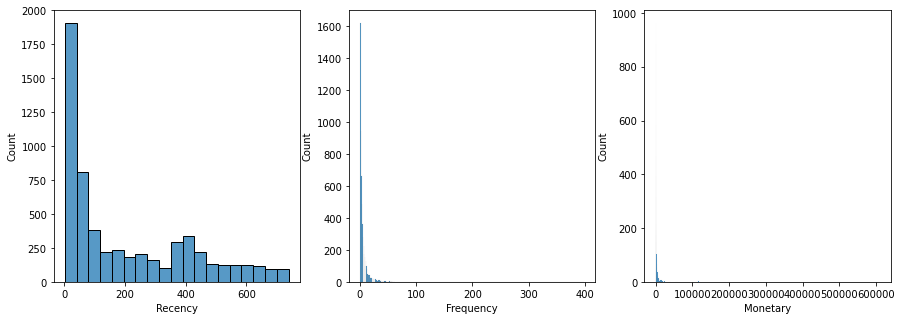

In [37]:
#Plot data distribution
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(data=rfm, x='Recency')

plt.subplot(1,3,2)
sns.histplot(data=rfm, x='Frequency')

plt.subplot(1,3,3)
sns.histplot(data=rfm, x='Monetary')

In [38]:
#apply log transformation 
for col in rfm.columns:
    rfm[col] = np.log(rfm[col])

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

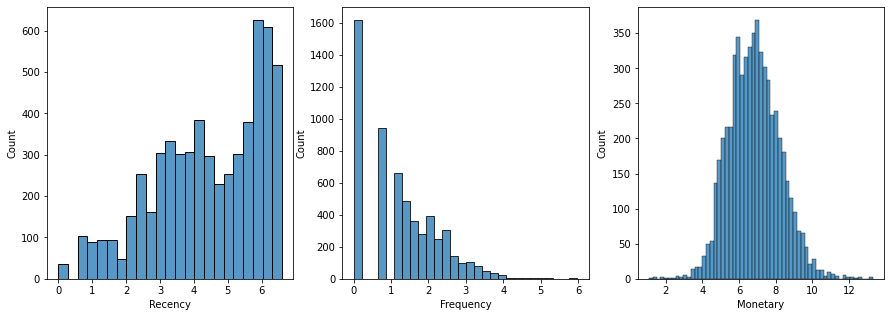

In [39]:
#Plot data distribution after log transformation
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(data=rfm, x='Recency')

plt.subplot(1,3,2)
sns.histplot(data=rfm, x='Frequency')

plt.subplot(1,3,3)
sns.histplot(data=rfm, x='Monetary')

## Feature Scaling

In [40]:
rfm_scaled = rfm.copy(deep=True)

In [41]:
scaler = StandardScaler().fit(rfm_scaled)
rfm_scaled = scaler.transform(rfm_scaled)

In [42]:
rfm_scaled

array([[ 0.84963041,  1.24639759,  3.17931188],
       [-2.08832957,  0.85225929,  1.29507418],
       [-0.06288912,  0.39538538,  0.55792307],
       ...,
       [ 1.29258896, -1.16909231, -0.55852705],
       [ 1.08814912, -0.49530845,  0.23947527],
       [-0.41979271,  0.72245814,  1.08118389]])

In [43]:
pd.DataFrame(rfm_scaled, columns=rfm.columns).describe()

,Recency,Frequency,Monetary
count,5.872000e+03,5.872000e+03,5.872000e+03
mean,3.630157e-16,6.715791e-17,5.711447e-16
std,1.000085e+00,1.000085e+00,1.000085e+00
min,-2.776786e+00,-1.169092e+00,-4.133258e+00
25%,-7.350675e-01,-1.169092e+00,-7.039033e-01
50%,8.350793e-02,-1.011701e-01,-2.340150e-02
75%,9.456810e-01,7.224581e-01,6.540793e-01
max,1.362489e+00,4.650126e+00,4.659881e+00


## K-Means